### Logistic Regression - Baseline Model for Churn Prediction

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

X_train = pd.read_csv('data/processed/X_train_scaled.csv')
X_test = pd.read_csv('data/processed/X_test_scaled.csv')
y_train = pd.read_csv('data/processed/y_train.csv')['churn']
y_test = pd.read_csv('data/processed/y_test.csv')['churn']

print(f"Training set: {X_train.shape}")
print(f"Test set (holdout): {X_test.shape}")
print(f"\nFeatures ({len(X_train.columns)}):")
print(X_train.columns.tolist())

print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nPercentage:")
print(y_train.value_counts(normalize=True) * 100)

Training set: (8000, 15)
Test set (holdout): (2000, 15)

Features (15):
['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'country_Germany', 'country_Spain', 'has_balance', 'age_group', 'balance_per_product', 'tenure_age_ratio']

Class distribution in training set:
churn
0    6370
1    1630
Name: count, dtype: int64

Percentage:
churn
0    79.625
1    20.375
Name: proportion, dtype: float64


### Model Configuration

Why Logistic Regression as baseline?
 - Fast and interpretable
 - Works well with scaled features
 - Provides probability estimates
 - Good baseline for comparison

In [2]:
classifier = LogisticRegression(
    max_iter=1000,           # Maximum iterations for convergence
    class_weight='balanced', # Handle class imbalance (3.91:1 ratio)
    solver='lbfgs',          # Good for small to medium datasets
    random_state=42          # Reproducibility
)

# SMOTE is applied inside each CV fold to prevent data leakage
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', classifier)
])

### Cross-Validation

We use imblearn.pipeline to ensure SMOTE is only applied to the training folds during cross-validation. This prevents data leakage, ensuring our test metrics are realistic


Using 5-Fold Stratified Cross-Validation
Each fold: ~1600 samples
Cross-Validation Results (5 folds)
Accuracy:  0.7077 (+/- 0.0114)
Precision: 0.3794 (+/- 0.0143)
Recall:    0.6828 (+/- 0.0284)
F1-Score:  0.4877 (+/- 0.0178)
ROC-AUC:   0.7654 (+/- 0.0207)

Training time: 1.94 seconds


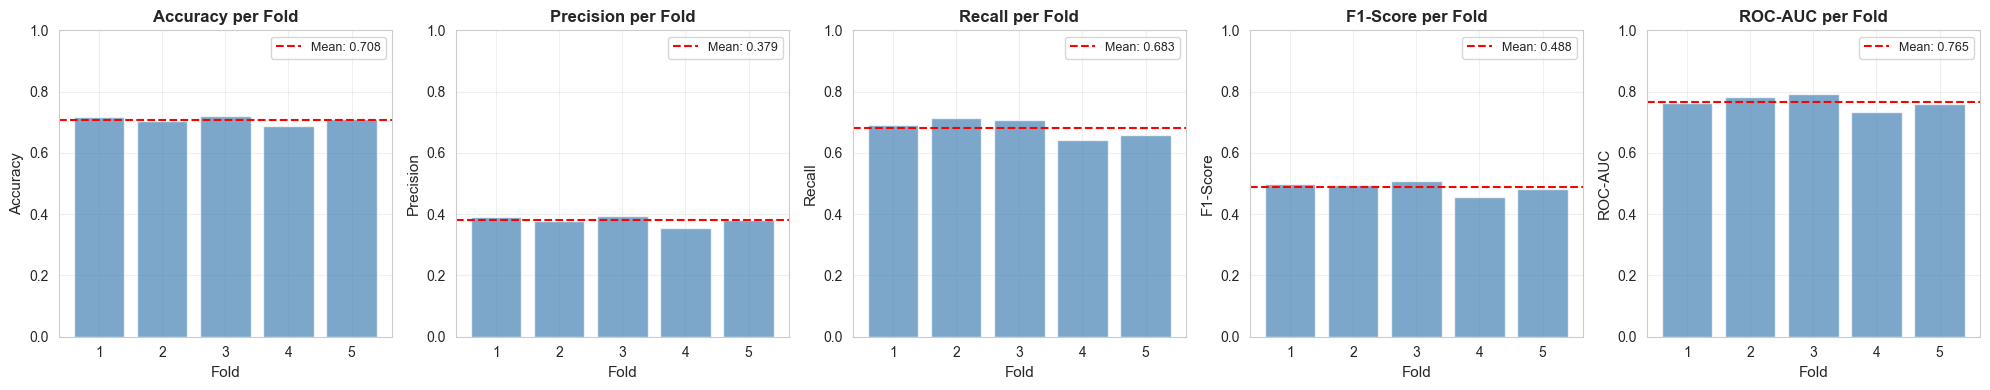

In [3]:
# Stratified ensures each fold has same class distribution (79.6/20.4)
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"\nUsing {n_folds}-Fold Stratified Cross-Validation")
print(f"Each fold: ~{len(X_train)//n_folds} samples")

# Score metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

start_time = time.time()

# Perform cross-validation
# SMOTE is applied inside each fold automatically by the pipeline
cv_scores = cross_validate(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1  # Use all CPU cores
)

elapsed_time = time.time() - start_time

print("Cross-Validation Results (5 folds)")
print(f"Accuracy:  {cv_scores['test_accuracy'].mean():.4f} (+/- {cv_scores['test_accuracy'].std():.4f})")
print(f"Precision: {cv_scores['test_precision'].mean():.4f} (+/- {cv_scores['test_precision'].std():.4f})")
print(f"Recall:    {cv_scores['test_recall'].mean():.4f} (+/- {cv_scores['test_recall'].std():.4f})")
print(f"F1-Score:  {cv_scores['test_f1'].mean():.4f} (+/- {cv_scores['test_f1'].std():.4f})")
print(f"ROC-AUC:   {cv_scores['test_roc_auc'].mean():.4f} (+/- {cv_scores['test_roc_auc'].std():.4f})")
print(f"\nTraining time: {elapsed_time:.2f} seconds")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    scores_per_fold = cv_scores[f'test_{metric}']
    axes[idx].bar(range(1, 6), scores_per_fold, alpha=0.7, color='steelblue')
    axes[idx].axhline(y=scores_per_fold.mean(), color='red', linestyle='--', 
                     label=f'Mean: {scores_per_fold.mean():.3f}')
    axes[idx].set_xlabel('Fold', fontsize=11)
    axes[idx].set_ylabel(name, fontsize=11)
    axes[idx].set_title(f'{name} per Fold', fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Train on full training set

In [4]:
pipeline.fit(X_train, y_train)

,steps,"[('smote', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False


### Evaluate on Hold-Out test set

In [5]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nTest Set Results (2,000 samples):")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f} (of predicted churners, {test_precision*100:.1f}% actually churned)")
print(f"Recall:    {test_recall:.4f} (caught {test_recall*100:.1f}% of actual churners)")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

# Detailed classification report
print("Detailed Classification Report")
print(classification_report(y_test, y_pred, 
                          target_names=['Not Churned', 'Churned'],
                          digits=4))


Test Set Results (2,000 samples):
Accuracy:  0.7185
Precision: 0.3929 (of predicted churners, 39.3% actually churned)
Recall:    0.7027 (caught 70.3% of actual churners)
F1-Score:  0.5040
ROC-AUC:   0.7744
Detailed Classification Report
              precision    recall  f1-score   support

 Not Churned     0.9049    0.7225    0.8035      1593
     Churned     0.3929    0.7027    0.5040       407

    accuracy                         0.7185      2000
   macro avg     0.6489    0.7126    0.6537      2000
weighted avg     0.8007    0.7185    0.7425      2000



### Confusion Matrix


Confusion Matrix:
                Predicted
              Not  Churned
Actual Not  [ 1151    442]
       Yes  [  121    286]

Breakdown:
  • True Negatives (correctly predicted not churned): 1151
  • False Positives (wrongly predicted churned): 442
  • False Negatives (missed churners): 121
  • True Positives (correctly predicted churned): 286


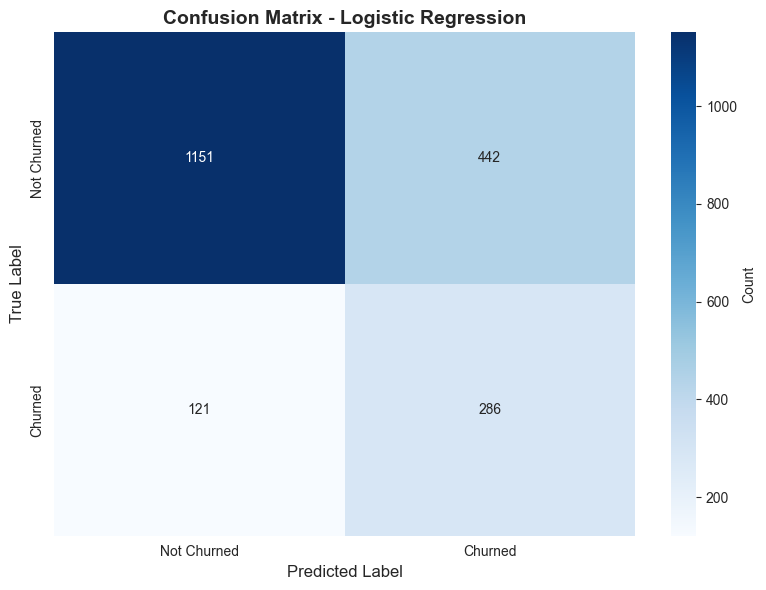

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print("                Predicted")
print("              Not  Churned")
print(f"Actual Not  [{cm[0,0]:5d}  {cm[0,1]:5d}]")
print(f"       Yes  [{cm[1,0]:5d}  {cm[1,1]:5d}]")

print("\nBreakdown:")
print(f"  • True Negatives (correctly predicted not churned): {cm[0,0]}")
print(f"  • False Positives (wrongly predicted churned): {cm[0,1]}")
print(f"  • False Negatives (missed churners): {cm[1,0]}")
print(f"  • True Positives (correctly predicted churned): {cm[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

### ROC CURVE

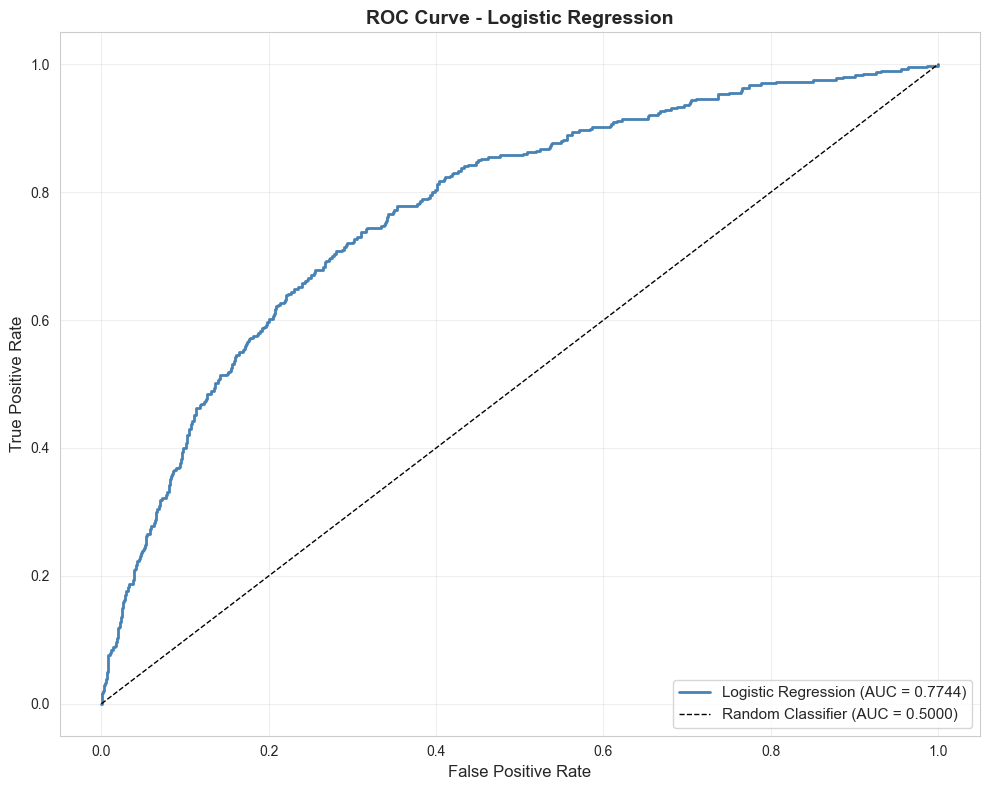


ROC-AUC Score: 0.7744
Interpretation:
  -Random classifier: 0.5000
  -Our model: 0.7744
  -Improvement: 27.4% better than random


In [7]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {test_roc_auc:.4f})', 
         linewidth=2, color='steelblue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {test_roc_auc:.4f}")
print("Interpretation:")
print("  -Random classifier: 0.5000")
print(f"  -Our model: {test_roc_auc:.4f}")
print(f"  -Improvement: {(test_roc_auc - 0.5)*100:.1f}% better than random")

### Precision-Recall Curve
- More informative than ROC for imbalanced datasets
- Shows trade-off between precision and recall
- Useful for choosing optimal threshold

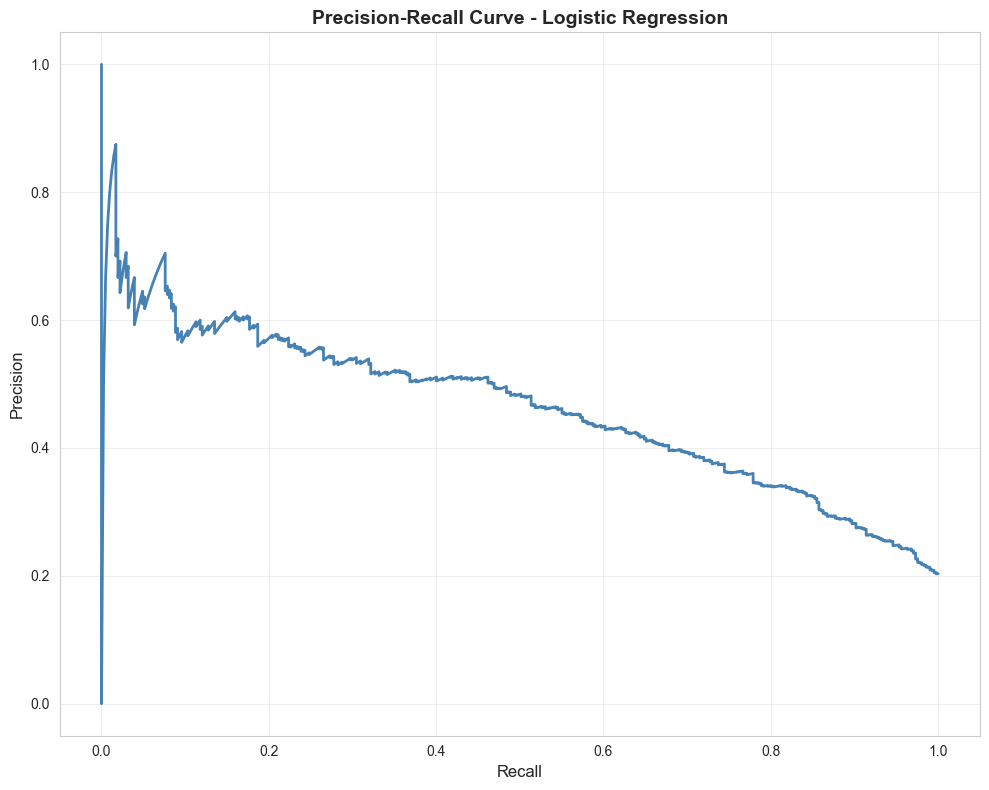

In [8]:
# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linewidth=2, color='steelblue')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Importance (Coefficients)


Top 10 Most Important Features (by absolute coefficient):
         Feature  Coefficient
             age     0.691788
tenure_age_ratio    -0.576416
          tenure     0.473157
   active_member    -0.461754
 country_Germany     0.374401
          gender    -0.273311
         balance     0.151812
 products_number    -0.123451
    credit_score    -0.070475
estimated_salary     0.068043

Interpretation:
  • Positive coefficient → increases probability of churn
  • Negative coefficient → decreases probability of churn
  • Larger absolute value → stronger influence


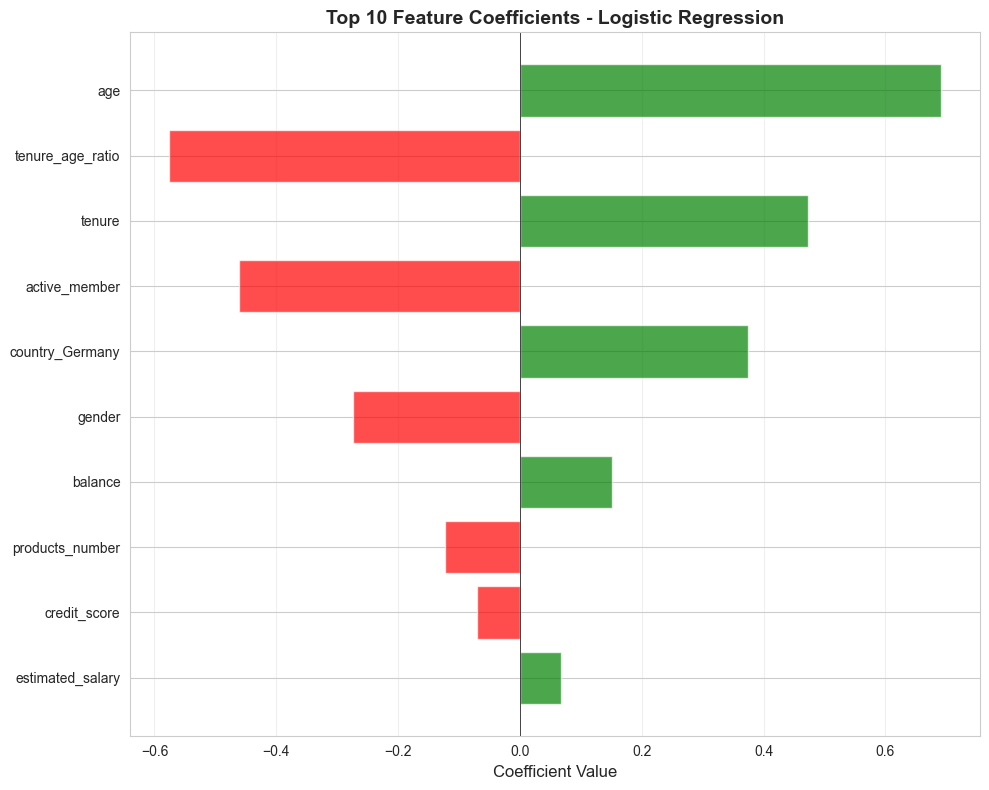


All Feature Coefficients:
            Feature  Coefficient
                age     0.691788
   tenure_age_ratio    -0.576416
             tenure     0.473157
      active_member    -0.461754
    country_Germany     0.374401
             gender    -0.273311
            balance     0.151812
    products_number    -0.123451
       credit_score    -0.070475
   estimated_salary     0.068043
        has_balance     0.047613
          age_group    -0.037804
balance_per_product    -0.035414
      country_Spain     0.020784
        credit_card    -0.003409


In [9]:
# Get trained logistic regression model from pipeline
lr_model = pipeline.named_steps['classifier']

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (by absolute coefficient):")
print(coefficients.head(10).to_string(index=False))

print("\nInterpretation:")
print("  • Positive coefficient → increases probability of churn")
print("  • Negative coefficient → decreases probability of churn")
print("  • Larger absolute value → stronger influence")

# Visualize top 10 coefficients
plt.figure(figsize=(10, 8))
top_10 = coefficients.head(10)
colors = ['red' if x < 0 else 'green' for x in top_10['Coefficient']]
plt.barh(range(len(top_10)), top_10['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 10 Feature Coefficients - Logistic Regression', 
         fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# All coefficients
print("\nAll Feature Coefficients:")
print(coefficients.to_string(index=False))

### Save results

In [13]:
results_lr = pd.DataFrame({
    'y_test': y_test.values,
    'y_pred': y_pred,
    'y_proba': y_pred_proba
})

results_lr.to_csv(
    'data/processed/logistic_regression_results.csv',
    index=False
)

We focus on ROC-AUC and F1-Score rather than Accuracy. In churn prediction, a False Negative (missing a churner) is much more expensive for the bank than a False Positive

### Model Summary

In [11]:
print(f"""
Model: Logistic Regression (Baseline)

Cross-Validation Performance (5-fold):
  - Mean Accuracy:  {cv_scores['test_accuracy'].mean():.4f} Std: {cv_scores['test_accuracy'].std():.4f}
  - Mean Precision: {cv_scores['test_precision'].mean():.4f} Std: {cv_scores['test_precision'].std():.4f}
  - Mean Recall:    {cv_scores['test_recall'].mean():.4f} Std: {cv_scores['test_recall'].std():.4f}
  - Mean F1-Score:  {cv_scores['test_f1'].mean():.4f} Std: {cv_scores['test_f1'].std():.4f}
  - Mean ROC-AUC:   {cv_scores['test_roc_auc'].mean():.4f} Std: {cv_scores['test_roc_auc'].std():.4f}
Test Set Performance (holdout):
  - Accuracy:  {test_accuracy:.4f}
  - Precision: {test_precision:.4f}
  - Recall:    {test_recall:.4f}
  - F1-Score:  {test_f1:.4f}
  - ROC-AUC:   {test_roc_auc:.4f}

Training Time: {elapsed_time:.2f} seconds
""")


Model: Logistic Regression (Baseline)

Cross-Validation Performance (5-fold):
  - Mean Accuracy:  0.7077 Std: 0.0114
  - Mean Precision: 0.3794 Std: 0.0143
  - Mean Recall:    0.6828 Std: 0.0284
  - Mean F1-Score:  0.4877 Std: 0.0178
  - Mean ROC-AUC:   0.7654 Std: 0.0207
Test Set Performance (holdout):
  - Accuracy:  0.7185
  - Precision: 0.3929
  - Recall:    0.7027
  - F1-Score:  0.5040
  - ROC-AUC:   0.7744

Training Time: 1.94 seconds

